In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import pandas as pd
import os
from PIL import Image,ImageEnhance
from transformers import AutoFeatureExtractor
from transformers import BertTokenizer

In [2]:
# 检查所有文件是否都被传输成功
import os

def count_files_in_directory(directory_path):
    entries = os.listdir(directory_path)
    files = [entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))]
    return len(files)

directory_path = './data'  
file_count = count_files_in_directory(directory_path)
print(f"有 {file_count} 个文件")

有 9738 个文件


In [3]:
tokenizer = BertTokenizer.from_pretrained('./pretrained_model/bert-base-uncased')
feature_extractor = AutoFeatureExtractor.from_pretrained("./pretrained_model/resnet-50")

/root/miniconda3/lib/python3.12/site-packages/transformers/models/convnext/feature_extraction_convnext.py:28: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [12]:
import random
# 随机裁剪
def cropping(image):
    width, height = image.size
    min_crop_width, min_crop_height = int(width * 0.5), int(height * 0.5)
    max_crop_width, max_crop_height = int(width * 0.8), int(height * 0.8)

    crop_width = random.randint(min_crop_width, max_crop_width)
    crop_height = random.randint(min_crop_height, max_crop_height)

    max_x = width - crop_width
    max_y = height - crop_height

    left = random.randint(0, max_x)
    top = random.randint(0, max_y)
    return image.crop((left, top, left + crop_width, top + crop_height))
# 数据增强   
def augment_image(image):
    augmented_images = []
    # 翻转
    flipped_img = image.transpose(Image.FLIP_LEFT_RIGHT)
    augmented_images.append(flipped_img)
    # 随机裁剪
    cropped_image1 = cropping(image)
    cropped_image2 = cropping(image)
    augmented_images.extend([cropped_image1, cropped_image2])
    # 色彩变化
    enhancer = ImageEnhance.Color(image)
    color_enhanced_img = enhancer.enhance(1.5)
    augmented_images.append(color_enhanced_img)
    
    return augmented_images

# 处理训练集数据
def get_train_data_list(data_folder_path = './data'):
    train_data_list = []
    train_label_path = './train.txt'
    # 简化标签
    train_label = pd.read_csv(train_label_path)
    tag_mapping = {
        'negative': 0,
        'neutral': 1,
        'positive': 2,
    }
    
    for idx, (guid, tag) in enumerate(train_label.values):
        data_dict = {}
        data_dict['guid'] = int(guid)
        data_dict['tag'] = tag_mapping[tag]
        file_path_image = os.path.join(data_folder_path, f'{int(guid)}.jpg')
        file_path_text = os.path.join(data_folder_path, f'{int(guid)}.txt')
        image = Image.open(file_path_image)
        text = None
        with open(file_path_text, 'rb') as f:
            text = f.readline().strip()
        data_dict['image'], data_dict['text'] = image, text
        train_data_list.append(data_dict)
        
    return train_data_list
    
'''
def get_train_data_list(data_folder_path='./data', split_ratio=0.75):
    train_data_list = []
    valid_data_list = []
    train_label_path = './train.txt'
    
    train_label = pd.read_csv(train_label_path)
    tag_mapping = {
        'negative': 0,
        'neutral': 1,
        'positive': 2,
    }

    all_data = []
    for idx, (guid, tag) in enumerate(train_label.values):
        data_dict = {}
        data_dict['guid'] = int(guid)
        data_dict['tag'] = tag_mapping[tag]
        file_path_image = os.path.join(data_folder_path, f'{int(guid)}.jpg')
        file_path_text = os.path.join(data_folder_path, f'{int(guid)}.txt')

        image = Image.open(file_path_image)
        text = None
        with open(file_path_text, 'rb') as f:
            text = f.readline().strip()
        
        data_dict['image'], data_dict['text'] = image, text
        all_data.append(data_dict)

    random.shuffle(all_data)

    split_idx = int(len(all_data) * split_ratio)
    train_data = all_data[:split_idx]
    valid_data = all_data[split_idx:]

    for data_dict in train_data:
        augmented_images = augment_image(data_dict['image'])
        for img in augmented_images:
            new_data_dict = data_dict.copy()
            new_data_dict['image'], new_data_dict['text'] = img, data_dict['text']
            train_data_list.append(new_data_dict)

    valid_data_list.extend(valid_data)

    return train_data_list, valid_data_list
'''

"\ndef get_train_data_list(data_folder_path='./data', split_ratio=0.75):\n    train_data_list = []\n    valid_data_list = []\n    train_label_path = './train.txt'\n    \n    train_label = pd.read_csv(train_label_path)\n    tag_mapping = {\n        'negative': 0,\n        'neutral': 1,\n        'positive': 2,\n    }\n\n    all_data = []\n    for idx, (guid, tag) in enumerate(train_label.values):\n        data_dict = {}\n        data_dict['guid'] = int(guid)\n        data_dict['tag'] = tag_mapping[tag]\n        file_path_image = os.path.join(data_folder_path, f'{int(guid)}.jpg')\n        file_path_text = os.path.join(data_folder_path, f'{int(guid)}.txt')\n\n        image = Image.open(file_path_image)\n        text = None\n        with open(file_path_text, 'rb') as f:\n            text = f.readline().strip()\n        \n        data_dict['image'], data_dict['text'] = image, text\n        all_data.append(data_dict)\n\n    random.shuffle(all_data)\n\n    split_idx = int(len(all_data) * split

In [5]:
# 处理测试集数据
def get_test_data_list():
    test_data_list = []
    test_label_path = 'test_without_label.txt'
    data_folder_path = './data'
    
    test_label = pd.read_csv(test_label_path)

    for guid, tag in test_label.values:
        data_dict = {}
        data_dict['guid'] = int(guid)
        data_dict['tag'] = None
        file_path_image = os.path.join(data_folder_path, f'{int(guid)}.jpg')
        file_path_text = os.path.join(data_folder_path, f'{int(guid)}.txt')
        image = Image.open(file_path_image)
        text = None
        with open(file_path_text, 'rb') as f:
            text = f.readline().strip()
        data_dict['image'], data_dict['text'] = image, text
        test_data_list.append(data_dict)

    return test_data_list

In [6]:
def text_decode(text: bytes):
    try:
        decode = text.decode(encoding='utf-8')
    except:
        try: 
            decode = text.decode(encoding='GBK')
        except:
            decode = text.decode(encoding='gb18030')
    return decode

def data_preprocess(data_list):
    for data in data_list:
        data['text'] = text_decode(data['text'])

    return data_list

In [7]:
# 返回guid, 标签，处理后的图片，解码后的文本
def collate_fn(data_list):
    guid = [data['guid'] for data in data_list]
    tag = [data['tag'] for data in data_list]
    image = [data['image'] for data in data_list]
    image = feature_extractor(image, return_tensors="pt")
    text = [data['text'] for data in data_list]
    text = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=100)

    return guid, None if tag[0] == None else torch.LongTensor(tag), image, text

# 划分数据集并创建训练集、验证集的DataLoader
def get_train_data_loader() -> (DataLoader, DataLoader):
    train_data_list= get_train_data_list()
    train_data_list = data_preprocess(train_data_list)

    train_data_length = int(len(train_data_list) * 0.75)
    valid_data_length = len(train_data_list) - train_data_length
    train_dataset, valid_dataset = random_split(dataset=train_data_list, lengths = [train_data_length, valid_data_length])

    train_data_loader = DataLoader(
        dataset=train_dataset,
        collate_fn=collate_fn,
        batch_size=16,
        shuffle=True,
        drop_last=False,
    )

    valid_data_loader = DataLoader(
        dataset=valid_dataset,
        collate_fn=collate_fn,
        batch_size=16,
        shuffle=True,
        drop_last=False,
    )

    return train_data_loader, valid_data_loader
'''
def get_train_data_loader() -> (DataLoader, DataLoader):
    train_data_list, valid_data_list = get_train_data_list()
    
    train_data_list = data_preprocess(train_data_list)
    valid_data_list = data_preprocess(valid_data_list)

    train_data_loader = DataLoader(
        dataset=train_data_list,
        collate_fn=collate_fn,
        batch_size=16,
        shuffle=True,
        drop_last=False,
    )

    valid_data_loader = DataLoader(
        dataset=valid_data_list,
        collate_fn=collate_fn,
        batch_size=16,
        shuffle=False,
        drop_last=False,
    )

    return train_data_loader, valid_data_loader
'''
# 创建测试集DataLoader
def get_test_data_loader() -> (DataLoader):
    test_data_list = get_test_data_list()
    test_data_list = data_preprocess(test_data_list)

    test_data_loader = DataLoader(
        dataset=test_data_list,
        collate_fn=collate_fn,
        batch_size=16,
        shuffle=False,
        drop_last=False,
    )

    return test_data_loader

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# 设置模型评测标准
def calc_metrics(target, pred):
    accuracy = accuracy_score(target, pred)
    precision_w = precision_score(target, pred, average='weighted')
    recall_w = recall_score(target, pred, average='weighted')
    f1_w = f1_score(target, pred, average='weighted')
    precision = precision_score(target, pred, average='macro')
    recall = recall_score(target, pred, average='macro')
    f1 = f1_score(target, pred, average='macro')
    return accuracy, precision_w, recall_w, f1_w, precision, recall, f1

In [9]:
device = None

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")

using GPU


In [10]:
from transformers import BertModel, BertPreTrainedModel
from transformers.models.bert.modeling_bert import BertLayer 
import torch.nn as nn

class AttentionAddModel(BertPreTrainedModel):
    def __init__(self, config):
        super(AttentionAddModel, self).__init__(config)
        self.bert = BertModel(config)
        self.resnet = ResNetModel.from_pretrained("./pretrained_model/resnet-50")
        self.comb_attention = BertLayer(config)  
        self.W = nn.Linear(in_features=2048, out_features=config.hidden_size)
        self.image_pool = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh()
        )
        self.text_pool = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh()
        )
        self.classifier_single = nn.Linear(in_features=config.hidden_size, out_features=3)

    def forward(self, image_input=None, text_input=None):
        if (image_input is not None) and (text_input is not None):
            text_features = self.bert(**text_input)
            text_hidden_state = text_features.last_hidden_state

            t = self.resnet(**image_input).last_hidden_state
            image_features = t.view(-1, 2048, 49).permute(0, 2, 1).contiguous()
            image_pooled_output, _ = image_features.max(1)
            image_hidden_state = self.W(image_pooled_output).unsqueeze(1)

            image_text_hidden_state = torch.cat([image_hidden_state, text_hidden_state], 1)

            attention_mask = text_input.attention_mask
            image_attention_mask = torch.ones((attention_mask.size(0), 1)).to(device)
            attention_mask = torch.cat([image_attention_mask, attention_mask], 1).unsqueeze(1).unsqueeze(2)
            attention_mask = (1.0 - attention_mask) * -10000

            image_text_attention_state = self.comb_attention(image_text_hidden_state, attention_mask)[0]

            image_pooled_output = self.image_pool(image_text_attention_state[:, 0, :])
            text_pooled_output = self.text_pool(image_text_attention_state[:, 1, :])
            final_output = torch.add(image_pooled_output, text_pooled_output)

            out = self.classifier_single(final_output)
            return out

In [21]:
import numpy as np
from transformers import ResNetModel
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)

torch.backends.cudnn.deterministic = True

class Arg:
    def __init__(self):
        self.lr = 2e-5
        self.epochs = 10
        self.weight_decay = 1e-4

args = Arg()

def model_train():
    train_data_loader, valid_data_loader = get_train_data_loader()
    test_data_loader = get_test_data_loader()
    model = AttentionAddModel.from_pretrained('./pretrained_model/bert-base-uncased')
    device = torch.device("cuda")
    model.to(device)
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(lr=args.lr, params=optimizer_grouped_parameters)
    criterion = CrossEntropyLoss()
    best_rate = 0
    print('START TRAINING: ')
    for epoch in range(args.epochs):
        total_loss = 0
        correct = 0
        total = 0
        target_list = []
        pred_list = []
        model.train()
        for idx, (guid, tag, image, text) in enumerate(train_data_loader):
            tag = tag.to(device)
            image = image.to(device)
            text = text.to(device)
            out = model(image_input=image, text_input=text)
            loss = criterion(out, tag)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item() * len(guid)
            pred = torch.max(out, 1)[1]
            total += len(guid)
            correct += (pred == tag).sum()

            target_list.extend(tag.cpu().tolist())
            pred_list.extend(pred.cpu().tolist())

        total_loss /= total
        print('EPOCH{:02d}: '.format(epoch + 1), end='')
        print('TRAIN LOSS: {:.6f} '.format(total_loss), end='')
        rate = correct / total * 100
        print('ACC_RATE: {:.2f}% '.format(rate), end='')
        metrics = calc_metrics(target_list, pred_list)
        print(metrics)
        
        total_loss = 0
        correct = 0
        total = 0
        target_list = []
        pred_list = []
        model.eval()

        for guid, tag, image, text in valid_data_loader:
            tag = tag.to(device)
            image = image.to(device)
            text = text.to(device)
            
            out = model(image_input=image, text_input=text)
            loss = criterion(out, tag)
            total_loss += loss.item() * len(guid)
            pred = torch.max(out, 1)[1]
            total += len(guid)
            correct += (pred == tag).sum()

            target_list.extend(tag.cpu().tolist())
            pred_list.extend(pred.cpu().tolist())

        total_loss /= total
        print('EVAL LOSS: {:.6f} '.format(total_loss), end='')
        rate = correct / total * 100
        print('ACC_RATE: {:.2f}% '.format(rate), end='')
        metrics = calc_metrics(target_list, pred_list)
        
        print(metrics)
        if rate > best_rate:
            best_rate = rate
            print('SAVING BEST ACC_RATE ON THE VALIDATION SET:{:.2f}% '.format(rate))
            torch.save(model.state_dict(), 'model.pth')
        print()
    print('END TRAINING')

model_train()

Some weights of AttentionAddModel were not initialized from the model checkpoint at ./pretrained_model/bert-base-uncased and are newly initialized: ['W.bias', 'W.weight', 'classifier_single.bias', 'classifier_single.weight', 'comb_attention.attention.output.LayerNorm.bias', 'comb_attention.attention.output.LayerNorm.weight', 'comb_attention.attention.output.dense.bias', 'comb_attention.attention.output.dense.weight', 'comb_attention.attention.self.key.bias', 'comb_attention.attention.self.key.weight', 'comb_attention.attention.self.query.bias', 'comb_attention.attention.self.query.weight', 'comb_attention.attention.self.value.bias', 'comb_attention.attention.self.value.weight', 'comb_attention.intermediate.dense.bias', 'comb_attention.intermediate.dense.weight', 'comb_attention.output.LayerNorm.bias', 'comb_attention.output.LayerNorm.weight', 'comb_attention.output.dense.bias', 'comb_attention.output.dense.weight', 'image_pool.0.bias', 'image_pool.0.weight', 'resnet.embedder.embedder.c

START TRAINING: 
EPOCH01: TRAIN LOSS: 0.744150 ACC_RATE: 67.47% (0.6746666666666666, 0.6572058430620275, 0.6746666666666666, 0.6458417723840189, 0.6178796815239513, 0.49061627240800565, 0.5017493582758447)
EVAL LOSS: 0.688642 ACC_RATE: 72.50% (0.725, 0.7231350780008332, 0.725, 0.7021612126245848, 0.7095262343059648, 0.5661770369971243, 0.5816740494647471)
SAVING BEST ACC_RATE ON THE VALIDATION SET:72.50% 

EPOCH02: TRAIN LOSS: 0.504153 ACC_RATE: 79.73% (0.7973333333333333, 0.7902263289982003, 0.7973333333333333, 0.786092772164582, 0.7542148731802758, 0.6586035196891918, 0.6826911540196909)
EVAL LOSS: 0.678060 ACC_RATE: 72.70% (0.727, 0.7111634437198361, 0.727, 0.7100240306358764, 0.6525623054197284, 0.5797087067670073, 0.5937994882992567)
SAVING BEST ACC_RATE ON THE VALIDATION SET:72.70% 

EPOCH03: TRAIN LOSS: 0.317570 ACC_RATE: 88.10% (0.881, 0.8786831072699701, 0.881, 0.878563492672557, 0.8529497052016821, 0.8056986225236932, 0.8254958103420478)
EVAL LOSS: 0.813199 ACC_RATE: 71.00% (

In [15]:
class CatModel(BertPreTrainedModel):
    def __init__(self, config):
        super(CatModel, self).__init__(config)
        self.hidden_size = config.hidden_size
        self.bert = BertModel(config)
        self.resnet = ResNetModel.from_pretrained("./pretrained_model/resnet-50")
        self.comb_attention = BertLayer(config)
        self.W = nn.Linear(in_features=2048, out_features=config.hidden_size)
        self.image_pool = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh()
        )
        self.text_pool = nn.Sequential (
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh()
        )
        self.classifier = nn.Linear(in_features=config.hidden_size * 2, out_features=3)
        self.classifier_single = nn.Linear(in_features=config.hidden_size, out_features=3)

    def forward(self, image_input = None, text_input = None):
        if (image_input is not None) and (text_input is not None):
            text_features = self.bert(**text_input)
            text_hidden_state, _ = text_features.last_hidden_state.max(1)
            
            t = self.resnet(**image_input).last_hidden_state
            image_features = t.view(-1, 2048, 49).permute(0, 2, 1).contiguous()
            image_pooled_output, _ = image_features.max(1)
            image_hidden_state = self.W(image_pooled_output).unsqueeze(1).view(-1, self.hidden_size)
 
            image_text_hidden_state = torch.cat([image_hidden_state, text_hidden_state], 1)

            out = self.classifier(image_text_hidden_state)
            return out

In [17]:
def model_cat_train():
    train_data_loader, valid_data_loader = get_train_data_loader()
    test_data_loader = get_test_data_loader()
    model = CatModel.from_pretrained('./pretrained_model/bert-base-uncased')
    device = torch.device("cuda")
    model.to(device)
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(lr=args.lr, params=optimizer_grouped_parameters)
    criterion = CrossEntropyLoss()
    best_rate = 0
    print('START TRAINING')
    for epoch in range(args.epochs):
        total_loss = 0
        correct = 0
        total = 0
        target_list = []
        pred_list = []
        model.train()
        for idx, (guid, tag, image, text) in enumerate(train_data_loader):
            tag = tag.to(device)
            image = image.to(device)
            text = text.to(device)
            out = model(image_input=image, text_input=text)
            loss = criterion(out, tag)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item() * len(guid)
            pred = torch.max(out, 1)[1]
            total += len(guid)
            correct += (pred == tag).sum()

            target_list.extend(tag.cpu().tolist())
            pred_list.extend(pred.cpu().tolist())

        total_loss /= total
        print('EPOCH{:02d}: '.format(epoch + 1), end='')
        print('TRAIN LOSS:{:.6f} '.format(total_loss), end='')
        rate = correct / total * 100
        print('ACC_RATE:{:.2f}% '.format(rate), end='')
        metrics = calc_metrics(target_list, pred_list)
        print(metrics)
        
        correct = 0
        total = 0
        target_list = []
        pred_list = []
        model.eval()

        for guid, tag, image, text in valid_data_loader:
            tag = tag.to(device)
            image = image.to(device)
            text = text.to(device)
            
            out = model(image_input=image, text_input=text)
            loss = criterion(out, tag)
            total_loss += loss.item() * len(guid)
            pred = torch.max(out, 1)[1]
            total += len(guid)
            correct += (pred == tag).sum()

            target_list.extend(tag.cpu().tolist())
            pred_list.extend(pred.cpu().tolist())

        total_loss /= total
        print('EVAL LOSS:{:.6f} '.format(total_loss), end='')
        rate = correct / total * 100
        print('ACC_RATE:{:.2f}% '.format(rate), end='')
        metrics = calc_metrics(target_list, pred_list)
        print(metrics)
        if rate > best_rate:
            best_rate = rate
            print('SAVING BEST ACC_RATE ON THE VALIDATION SET:{:.2f}%'.format(rate))
            torch.save(model.state_dict(), 'model.pth')
        print()
    print('END TRAINING')

model_cat_train()

Some weights of CatModel were not initialized from the model checkpoint at ./pretrained_model/bert-base-uncased and are newly initialized: ['W.bias', 'W.weight', 'classifier.bias', 'classifier.weight', 'classifier_single.bias', 'classifier_single.weight', 'comb_attention.attention.output.LayerNorm.bias', 'comb_attention.attention.output.LayerNorm.weight', 'comb_attention.attention.output.dense.bias', 'comb_attention.attention.output.dense.weight', 'comb_attention.attention.self.key.bias', 'comb_attention.attention.self.key.weight', 'comb_attention.attention.self.query.bias', 'comb_attention.attention.self.query.weight', 'comb_attention.attention.self.value.bias', 'comb_attention.attention.self.value.weight', 'comb_attention.intermediate.dense.bias', 'comb_attention.intermediate.dense.weight', 'comb_attention.output.LayerNorm.bias', 'comb_attention.output.LayerNorm.weight', 'comb_attention.output.dense.bias', 'comb_attention.output.dense.weight', 'image_pool.0.bias', 'image_pool.0.weigh

START TRAINING
EPOCH01: TRAIN LOSS:0.904655 ACC_RATE:59.90% (0.599, 0.5624662843126587, 0.599, 0.571162919154322, 0.46890964687336406, 0.42663600948677916, 0.4274892812482926)
EVAL LOSS:0.727487 ACC_RATE:69.10% (0.691, 0.6879169620812094, 0.691, 0.6677347888988909, 0.6155525432966688, 0.5488588896483634, 0.5602001553590336)
SAVING BEST ACC_RATE ON THE VALIDATION SET:69.10%

EPOCH02: TRAIN LOSS:0.607465 ACC_RATE:75.37% (0.7536666666666667, 0.7421435869719298, 0.7536666666666667, 0.7428303937441239, 0.6871534104779919, 0.6206201853435559, 0.6403147382573071)
EVAL LOSS:0.656805 ACC_RATE:73.40% (0.734, 0.7184623516320474, 0.734, 0.7116514674123077, 0.6562670078892943, 0.553647376015797, 0.5591801966730627)
SAVING BEST ACC_RATE ON THE VALIDATION SET:73.40%

EPOCH03: TRAIN LOSS:0.412193 ACC_RATE:84.33% (0.8433333333333334, 0.8377938858927226, 0.8433333333333334, 0.8376009589661741, 0.8006792921413557, 0.7389726239960489, 0.7617337747062795)
EVAL LOSS:0.690098 ACC_RATE:72.50% (0.725, 0.714817

In [19]:
import numpy as np
from transformers import ResNetModel
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss

torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)

torch.backends.cudnn.deterministic = True

class Arg_attention_cat:
    def __init__(self):
        self.lr = 2e-5
        self.epochs = 20
        self.weight_decay = 1e-4

args = Arg_attention_cat()

class AttentionCatModel(BertPreTrainedModel):
    def __init__(self, config):
        super(AttentionCatModel, self).__init__(config)
        self.bert = BertModel(config)
        self.resnet = ResNetModel.from_pretrained("./pretrained_model/resnet-50")
        self.comb_attention = BertLayer(config)
        self.W = nn.Linear(in_features=2048, out_features=config.hidden_size)
        self.image_pool = nn.Sequential(
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh()
        )
        self.text_pool = nn.Sequential (
            nn.Linear(config.hidden_size, config.hidden_size),
            nn.Tanh()
        )
        self.classifier = nn.Linear(in_features=config.hidden_size * 2, out_features=3)
        self.classifier_single = nn.Linear(in_features=config.hidden_size, out_features=3)

    def forward(self, image_input = None, text_input = None):
        if (image_input is not None) and (text_input is not None):
            text_features = self.bert(**text_input)
            text_hidden_state = text_features.last_hidden_state

            t = self.resnet(**image_input).last_hidden_state
            image_features = t.view(-1, 2048, 49).permute(0, 2, 1).contiguous()
            image_pooled_output, _ = image_features.max(1)
            image_hidden_state = self.W(image_pooled_output).unsqueeze(1)
            image_text_hidden_state = torch.cat([image_hidden_state, text_hidden_state], 1)

            attention_mask = text_input.attention_mask
            image_attention_mask = torch.ones((attention_mask.size(0), 1)).to(device)
            attention_mask = torch.cat([image_attention_mask, attention_mask], 1).unsqueeze(1).unsqueeze(2)
            attention_mask = (1.0 - attention_mask) * -10000
 
            image_text_attention_state = self.comb_attention(image_text_hidden_state, attention_mask)[0]
            image_pooled_output = self.image_pool(image_text_attention_state[:, 0, :])
            text_pooled_output = self.text_pool(image_text_attention_state[:, 1, :])
            final_output = torch.cat([image_pooled_output, text_pooled_output], 1)

            out = self.classifier(final_output)
            return out

def model_attention_cat_train():
    train_data_loader, valid_data_loader = get_train_data_loader()
    test_data_loader = get_test_data_loader()
    model = AttentionCatModel.from_pretrained('./pretrained_model/bert-base-uncased')
    device = torch.device("cuda")
    model.to(device)
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(lr=args.lr, params=optimizer_grouped_parameters)
    criterion = CrossEntropyLoss()
    best_rate = 0
    print('START TRAINING')
    for epoch in range(args.epochs):
        total_loss = 0
        correct = 0
        total = 0
        target_list = []
        pred_list = []
        model.train()
        for idx, (guid, tag, image, text) in enumerate(train_data_loader):
            tag = tag.to(device)
            image = image.to(device)
            text = text.to(device)
            out = model(image_input=image, text_input=text)
            loss = criterion(out, tag)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item() * len(guid)
            pred = torch.max(out, 1)[1]
            total += len(guid)
            correct += (pred == tag).sum()

            target_list.extend(tag.cpu().tolist())
            pred_list.extend(pred.cpu().tolist())

        total_loss /= total
        print('EPOCH{:02d} '.format(epoch + 1), end='')
        print('TRAIN LOSS:{:.6f} '.format(total_loss), end='')
        rate = correct / total * 100
        print('ACC_RATE:{:.2f}% '.format(rate), end='')
        metrics = calc_metrics(target_list, pred_list)
        print(metrics)

        total_loss = 0
        correct = 0
        total = 0
        target_list = []
        pred_list = []
        model.eval()

        for guid, tag, image, text in valid_data_loader:
            tag = tag.to(device)
            image = image.to(device)
            text = text.to(device)
            
            out = model(image_input=image, text_input=text)
            loss = criterion(out, tag)
            total_loss += loss.item() * len(guid)
            pred = torch.max(out, 1)[1]
            total += len(guid)
            correct += (pred == tag).sum()

            target_list.extend(tag.cpu().tolist())
            pred_list.extend(pred.cpu().tolist())

        total_loss /= total
        print('EVAL LOSS:{:.6f} '.format(total_loss), end='')
        rate = correct / total * 100
        print('ACC_RATE:{:.2f}% '.format(rate), end='')
        metrics = calc_metrics(target_list, pred_list)

        print(metrics)
        if rate > best_rate:
            best_rate = rate
            print('SAVING BEST ACC_RATE ON THE VALIDATION SET:{:.2f}%'.format(rate))
            torch.save(model.state_dict(), 'model.pth')
        print()
    print('END TRAINING')
    
model_attention_cat_train()

Some weights of AttentionCatModel were not initialized from the model checkpoint at ./pretrained_model/bert-base-uncased and are newly initialized: ['W.bias', 'W.weight', 'classifier.bias', 'classifier.weight', 'classifier_single.bias', 'classifier_single.weight', 'comb_attention.attention.output.LayerNorm.bias', 'comb_attention.attention.output.LayerNorm.weight', 'comb_attention.attention.output.dense.bias', 'comb_attention.attention.output.dense.weight', 'comb_attention.attention.self.key.bias', 'comb_attention.attention.self.key.weight', 'comb_attention.attention.self.query.bias', 'comb_attention.attention.self.query.weight', 'comb_attention.attention.self.value.bias', 'comb_attention.attention.self.value.weight', 'comb_attention.intermediate.dense.bias', 'comb_attention.intermediate.dense.weight', 'comb_attention.output.LayerNorm.bias', 'comb_attention.output.LayerNorm.weight', 'comb_attention.output.dense.bias', 'comb_attention.output.dense.weight', 'image_pool.0.bias', 'image_poo

START TRAINING
EPOCH01 TRAIN LOSS:0.748758 ACC_RATE:67.53% (0.6753333333333333, 0.6545199329072089, 0.6753333333333333, 0.6479115938554963, 0.603746619582695, 0.4935968529944339, 0.5054906347589274)
EVAL LOSS:0.692321 ACC_RATE:72.10% (0.721, 0.7086469217195057, 0.721, 0.6909280895014727, 0.6838664734637772, 0.5412997188146711, 0.5606502925430029)
SAVING BEST ACC_RATE ON THE VALIDATION SET:72.10%

EPOCH02 TRAIN LOSS:0.512730 ACC_RATE:79.30% (0.793, 0.7843367230340487, 0.793, 0.7829828360091023, 0.7364364422982597, 0.6577623094531927, 0.6796997735084039)
EVAL LOSS:0.723204 ACC_RATE:71.60% (0.716, 0.7169672685299695, 0.716, 0.6953463070323671, 0.6676407630319741, 0.5643896941286348, 0.5614937100105435)

EPOCH03 TRAIN LOSS:0.299636 ACC_RATE:89.07% (0.8906666666666667, 0.8876361051959296, 0.8906666666666667, 0.887429676564957, 0.8581435267266779, 0.8050221374739183, 0.8263353827152691)
EVAL LOSS:0.843026 ACC_RATE:71.60% (0.716, 0.7113048656813032, 0.716, 0.7123086959639107, 0.61451792714064

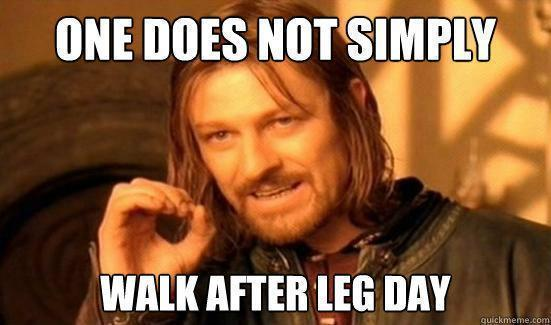

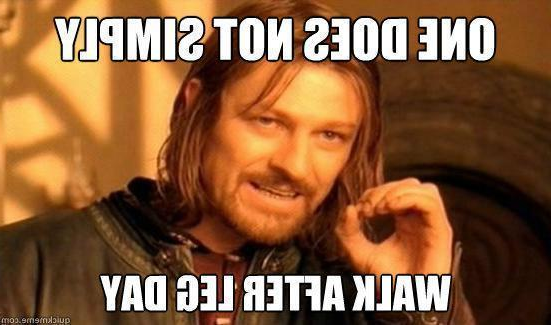

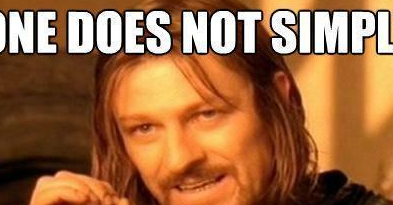

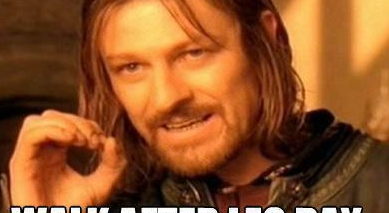

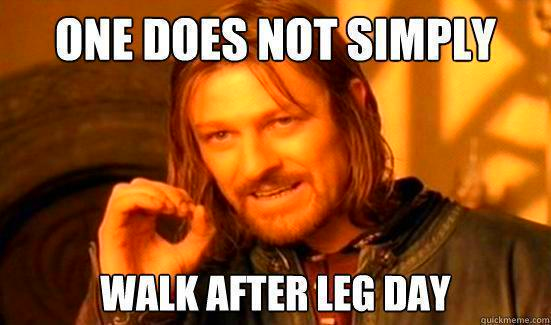

In [21]:
test_image = Image.open('./data/1.jpg')
test_image.show()
for img in augment_image(test_image):
    img.show()

In [20]:
def add_model_test():
    train_data_loader, valid_data_loader = get_train_data_loader()
    test_data_loader = get_test_data_loader()
    model = CatModel.from_pretrained('./pretrained_model/bert-base-uncased')
    model.load_state_dict(torch.load('model.pth'))
    model.to(device)

    guid_list = []
    pred_list = []
    model.eval()

    for guid, tag, image, text in test_data_loader:
        image = image.to(device)
        text = text.to(device)
        out = model(image_input=image, text_input=text)

        pred = torch.max(out, 1)[1]
        guid_list.extend(guid)
        pred_list.extend(pred.cpu().tolist())

    pred_mapped = {
        0: 'negative',
        1: 'neutral',
        2: 'positive',
    }
    
    with open('test_results/attention_cat.txt', 'w', encoding='utf-8') as f:
        f.write('guid,tag\n')
        for guid, pred in zip(guid_list, pred_list):
            f.write(f'{guid},{pred_mapped[pred]}\n')
        f.close()

add_model_test()

Some weights of CatModel were not initialized from the model checkpoint at ./pretrained_model/bert-base-uncased and are newly initialized: ['W.bias', 'W.weight', 'classifier.bias', 'classifier.weight', 'classifier_single.bias', 'classifier_single.weight', 'comb_attention.attention.output.LayerNorm.bias', 'comb_attention.attention.output.LayerNorm.weight', 'comb_attention.attention.output.dense.bias', 'comb_attention.attention.output.dense.weight', 'comb_attention.attention.self.key.bias', 'comb_attention.attention.self.key.weight', 'comb_attention.attention.self.query.bias', 'comb_attention.attention.self.query.weight', 'comb_attention.attention.self.value.bias', 'comb_attention.attention.self.value.weight', 'comb_attention.intermediate.dense.bias', 'comb_attention.intermediate.dense.weight', 'comb_attention.output.LayerNorm.bias', 'comb_attention.output.LayerNorm.weight', 'comb_attention.output.dense.bias', 'comb_attention.output.dense.weight', 'image_pool.0.bias', 'image_pool.0.weigh